In [1]:
import torch
import numpy as np

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 8

batch_size = 32
valid_size = 0.2

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root='data', train = False, download = True, transform = transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

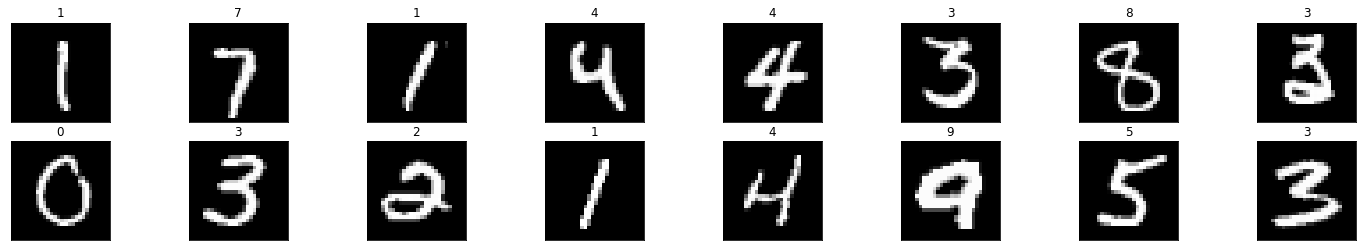

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

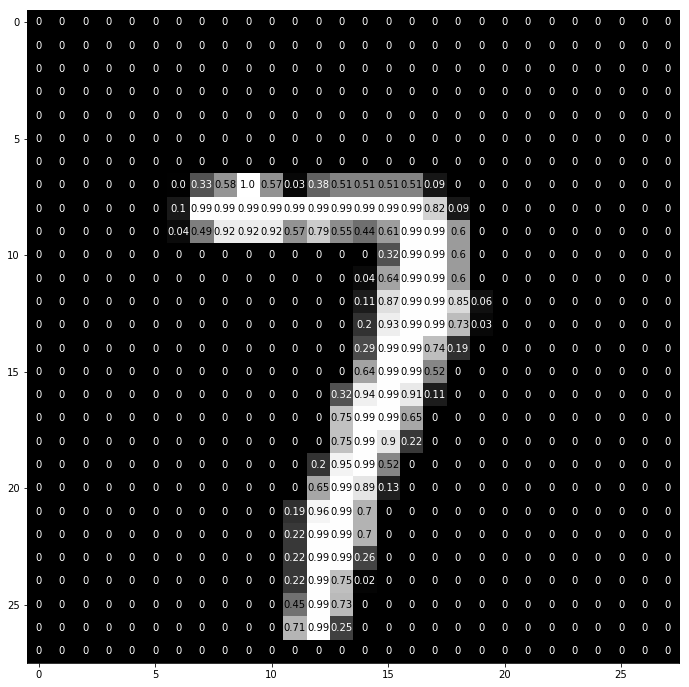

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(784, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        x = x.view(-1,784)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)
        
        return x

model = model()
print(model)     
model.to('cuda')

model(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


model(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [10]:
# training with hidden_layer2 = 512
epochs = 50

validation_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    for data, label in train_loader:
        data, label = data.to("cuda"), label.to("cuda")
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, label)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, label in valid_loader:
        data, label = data.to("cuda"), label.to("cuda")

        
        output = model(data)
        loss = criterion(output, label)
        val_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    val_loss = val_loss/len(test_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
        ))
    
    if val_loss <= validation_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        validation_loss_min,
        val_loss))
        torch.save(model.state_dict(), 'model.pt')
        validation_loss_min = val_loss

Epoch: 1 	Training Loss: 0.378947 	Validation Loss: 0.297508
Validation loss decreased (inf --> 0.297508).  Saving model ...
Epoch: 2 	Training Loss: 0.337541 	Validation Loss: 0.298496
Epoch: 3 	Training Loss: 0.326450 	Validation Loss: 0.286711
Validation loss decreased (0.297508 --> 0.286711).  Saving model ...
Epoch: 4 	Training Loss: 0.301684 	Validation Loss: 0.287772
Epoch: 5 	Training Loss: 0.302873 	Validation Loss: 0.308127
Epoch: 6 	Training Loss: 0.297474 	Validation Loss: 0.339299
Epoch: 7 	Training Loss: 0.291661 	Validation Loss: 0.286855
Epoch: 8 	Training Loss: 0.280042 	Validation Loss: 0.338519
Epoch: 9 	Training Loss: 0.275114 	Validation Loss: 0.292830
Epoch: 10 	Training Loss: 0.261612 	Validation Loss: 0.271707
Validation loss decreased (0.286711 --> 0.271707).  Saving model ...
Epoch: 11 	Training Loss: 0.276250 	Validation Loss: 0.312231
Epoch: 12 	Training Loss: 0.274440 	Validation Loss: 0.314517
Epoch: 13 	Training Loss: 0.253954 	Validation Loss: 0.313327
E

In [11]:
model.load_state_dict(torch.load('model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 
for data, target in test_loader:
    data, target = data.to("cuda"), target.to("cuda")

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
  
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
   
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.233449

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 96% (994/1032)
Test Accuracy of     3: 91% (921/1010)
Test Accuracy of     4: 95% (933/982)
Test Accuracy of     5: 94% (845/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 95% (977/1028)
Test Accuracy of     8: 92% (901/974)
Test Accuracy of     9: 94% (952/1009)

Test Accuracy (Overall): 95% (9538/10000)


In [14]:
model.to('')
dataiter = iter(test_loader)
images, labels = dataiter.next()


output = model(images)

_, preds = torch.max(output, 1)

images = images.numpy()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #4 'mat1'